In [1]:
#!/usr/bin/env python
# coding: utf-8

# Install necessary libraries
!pip install praw
!pip install transformers
!pip install matplotlib



In [16]:
import praw
from transformers import pipeline, DistilBertTokenizerFast, TFDistilBertModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
import datetime

# Set up Reddit API credentials
client_id = 'Si6w3dANV7wSwvmf3zj0Rg'
client_secret = 'O8r9Znu6azfUWhC8f2L4NxO524-jow'
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'


# Set up DistilBERT tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Define functions for text cleaning and preprocessing
def clean_text(text):
    text = re.sub(r"[@#]", "", text)
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    return text

def remove_stopwords(text):
    stopwords_list = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords_list]
    filtered_text = " ".join(filtered_words)
    return filtered_text

def preprocess_posts(posts):
    preprocessed_data = []
    for post in posts:
        cleaned_text = clean_text(str(post))

        filtered_text = remove_stopwords(cleaned_text)

        # Encode the text in chunks if it exceeds the maximum sequence length
        encoded_chunks = []
        for j in range(0, len(filtered_text), 512):
            chunk = tokenizer.encode(
                filtered_text[j : j + 512], truncation=True, max_length=512
            )
            encoded_chunks.extend(chunk)
        preprocessed_data.append(encoded_chunks)
    return preprocessed_data


# def preprocess_reddit_posts(posts):
#     preprocessed_data = []
#     for post in posts:
#         cleaned_text = clean_text(post)
#         filtered_text = remove_stopwords(cleaned_text)

#         # Encode the text in chunks if it exceeds the maximum sequence length
#         encoded_chunks = []
#         for j in range(0, len(filtered_text), 512):
#             chunk = tokenizer.encode(filtered_text[j:j+512], truncation=True, max_length=512)
#             encoded_chunks.extend(chunk)
        
#         # Truncate to match the maximum sequence length of the model
#         encoded_chunks = encoded_chunks[:512]

#         # Convert the encoded chunks back to text
#         text_chunks = tokenizer.decode(encoded_chunks, skip_special_tokens=True)
        
#         preprocessed_data.append(text_chunks)

#     return preprocessed_data


# Define function for sentiment analysis
def perform_sentiment_analysis(texts):
    sentiment_analysis_model = pipeline("sentiment-analysis")
    sentiment_predictions = sentiment_analysis_model(texts)
    return sentiment_predictions

# Define function for sentiment classification
def classify_sentiments(predictions):
    sentiment_classifications = []
    for prediction in predictions:
        label = prediction["label"]
        score = prediction["score"]

        if label == "POSITIVE" and score >= 0.5:
            sentiment = "positive"
        elif label == "NEGATIVE" and score >= 0.5:
            sentiment = "negative"
        else:
            sentiment = "neutral"

        sentiment_classifications.append(sentiment)

    return sentiment_classifications

# Define function for generating sentiment analysis chart
# def generate_sentiment_chart(subreddit_name, brand_keyword, date, sentiment_scores):
#     # Convert date to string
#     date_str = date.strftime("%Y-%m-%d")

#     # Plotting
#     plt.figure(figsize=(10, 5))
#     plt.plot(sentiment_scores, marker="o", linestyle="-", color="b")
#     plt.title(f"Sentiment Analysis for {brand_keyword} in {subreddit_name} on {date_str}")
#     plt.xlabel("Time Period")
#     plt.ylabel("Sentiment Score")
#     plt.xticks(range(len(sentiment_scores)), [str(i) for i in range(1, len(sentiment_scores) + 1)])
#     plt.grid(True)
#     plt.show()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaura

In [17]:
def generate_sentiment_chart(subreddit_name, brand_keyword, date, sentiment_scores, sentiment_classifications):
    # Convert date to string
    date_str = date.strftime("%Y-%m-%d")

    # Plotting
    colors = []
    for sentiment in sentiment_classifications:
        if sentiment == "positive":
            color = "green"
        elif sentiment == "negative":
            color = "red"
        else:
            color = "blue"

        colors.append(color)

    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(sentiment_scores)), sentiment_scores, c=colors, marker="o")
    plt.title(f"Sentiment Analysis for {brand_keyword} in {subreddit_name} on {date_str}")
    plt.xlabel("Post number")
    plt.ylabel("Sentiment Score")
    plt.grid(True)
    plt.show()


In [28]:
subreddit_name = "IndianStockMarket"
brand_keyword = "Zomato"

In [29]:
import csv

# Define function for calculating sentiment metrics
def calculate_sentiment_metrics(sentiment_classifications, sentiment_scores):
    # Calculate sentiment metrics
    total_posts = len(sentiment_classifications)
    positive_posts = sentiment_classifications.count("positive")
    negative_posts = sentiment_classifications.count("negative")

    positive_rate = positive_posts / total_posts
    negative_rate = negative_posts / total_posts

    net_positive_rate = positive_posts / negative_posts if negative_posts > 0 else 0
    net_score = sum(sentiment_scores) / total_posts

    day_sentiment = "Positive" if net_score >= 0 else "Negative"
    day_score = sum(sentiment_scores) / positive_posts if day_sentiment == "Positive" else abs(sum(sentiment_scores)) / negative_posts

    # Export sentiment metrics to CSV file
    sentiment_metrics = {
        "total_posts": total_posts,
        "positive_posts": positive_posts,
        "negative_posts": negative_posts,
        "positive_rate": positive_rate,
        "negative_rate": negative_rate,
        "net_positive_rate": net_positive_rate,
        "net_score": net_score,
        "day_sentiment": day_sentiment,
        "day_score": day_score
    }

    with open(f"{brand_keyword}_sentiments.csv", 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=sentiment_metrics.keys())
        writer.writeheader()
        writer.writerow(sentiment_metrics)

    return sentiment_metrics

In [30]:
import praw.models as models


def main():
    # Get posts from a subreddit based on a brand keyword
    subreddit_name = "IndianStockMarket"
    brand_keyword = "Zomato"
#     reddit_obj = praw.Reddit(
#         client_id=client_id, client_secret=client_secret, user_agent=user_agent
#     )
    reddit_obj = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    cache_timeout=0  # Disable caching
    )
    subreddit = reddit_obj.subreddit(subreddit_name)
    # Set the desired date
    target_date = datetime.datetime(2022, 10, 4)

    # Filter posts by date
    posts = subreddit.search(query=brand_keyword, limit=100)
    

    # Preprocess Reddit posts
    preprocessed_data = preprocess_posts(posts)

    # Perform sentiment analysis
    # Convert preprocessed data to a list of strings
    text_list = []
    for post in preprocessed_data:
        for chunk in post:
            text_list.append(tokenizer.decode(chunk))

    # Perform sentiment analysis
    sentiment_predictions = perform_sentiment_analysis(text_list)


    # Classify sentiments
    sentiment_classifications = classify_sentiments(sentiment_predictions)

    # Display sentiment classifications
    for i, sentiment in enumerate(sentiment_classifications):
        print(f"Post {i + 1}: {sentiment}")
        
    # Generate line chart with color-coded points
    sentiment_scores = []
    for prediction in sentiment_predictions:
        sentiment_scores.append(prediction["score"])

    # Generate sentiment chart
    generate_sentiment_chart(subreddit_name, brand_keyword, target_date, sentiment_scores,sentiment_classifications)
    
    plt.savefig(f'{brand_keyword}_sentiment_chart.png')
    
    # Calculate and export sentiment metrics
    calculate_sentiment_metrics(sentiment_classifications, sentiment_scores)
    
  



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Post 1: positive
Post 2: positive
Post 3: positive
Post 4: positive
Post 5: positive
Post 6: positive
Post 7: positive
Post 8: positive
Post 9: positive
Post 10: positive
Post 11: positive
Post 12: positive
Post 13: negative
Post 14: positive
Post 15: positive
Post 16: negative
Post 17: positive
Post 18: positive
Post 19: positive
Post 20: positive
Post 21: positive
Post 22: positive
Post 23: positive
Post 24: positive
Post 25: positive
Post 26: positive
Post 27: positive
Post 28: positive
Post 29: positive
Post 30: positive
Post 31: positive
Post 32: positive
Post 33: positive
Post 34: positive
Post 35: positive
Post 36: positive
Post 37: positive
Post 38: positive
Post 39: positive
Post 40: positive
Post 41: positive
Post 42: positive
Post 43: positive
Post 44: positive
Post 45: positive
Post 46: positive
Post 47: positive
Post 48: positive
Post 49: positive
Post 50: positive
Post 51: positive
Post 52: positive
Post 53: positive
Post 54: positive
Post 55: positive
Post 56: positive
P

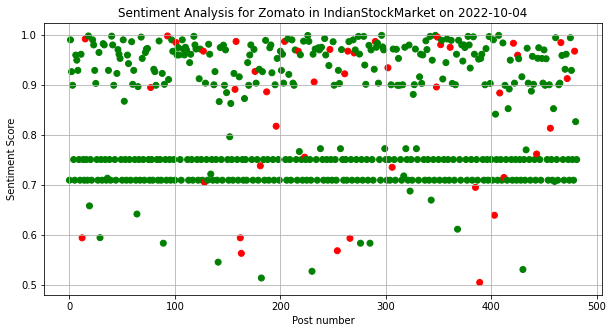

<Figure size 432x288 with 0 Axes>

In [31]:
# Run the main function
if __name__ == "__main__":
    main()